In [1]:
# OPERATIONAL PACKAGES ---------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import inf
import scipy as sp
from scipy.optimize import curve_fit

# STYLE RESOURCES ---------------------------------------
plt.style.reload_library()
plt.style.use(['science', 'grid'])

# FITTING PACKAGES ---------------------------------------
from lmfit import Model, Parameters
import scipy.optimize as optimization
from IPython.display import display, Markdown

In [44]:
# DEFINING A FUNCTION THAT RETURNS THE UNCERTAINTY USING VARIATIONAL METHOD ---------------------------------------
def uncertainty_var(values, deltas, function):
    values, deltas = np.array(values), np.array(deltas)
    delta_matrix = deltas*np.identity(values.shape[0])
    sum = 0
    for delta in delta_matrix:
        sum += (0.5*(abs(function(values + delta) - function(values)) + abs(function(values-delta) - function(values))))**2
    return np.sqrt(sum)

# FUNCTION FOR PLOTTING A SCATTER PLOT ---------------------------------------
def ScatterPlot(xdata,ydata,error_x,error_y,color,x_label,y_label):
    
    # SCATTER PLOT
    fig = plt.figure(figsize=(5, 5), dpi=80)
    plt.errorbar(xdata,ydata,yerr=error_y,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    plt.errorbar(xdata,ydata,xerr=error_x,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("Figures/figure1.png")
    
# DEFINING FITTING FUNCTIONS ---------------------------------------
getCurrent = lambda params : params[0]/params[1] # params = [V, R]
division = lambda params : params[0]/params[1]
XL = lambda f : 2*np.pi*f*6e-3
XC = lambda f : 1/(2*np.pi*f*1e-6)
f = lambda f, a : a/(np.sqrt(4.5**2 + (XL(f) - XC(f))**2))
power_normalized = lambda f, LR_ratio, f_0 : (1 + (2*np.pi*LR_ratio*(f**2 - f_0**2)/f)**2)**(-1)
def power_normalized2(params): # params = [f, LR_ratio, f_0]
    f, LR_ratio, f_0 = params[0], params[1], params[2]
    return (1 + (2*np.pi*LR_ratio*(f**2 - f_0**2)/f)**2)**(-1) 
p_ave = lambda params : 0.5*(params[0]**2)*params[1] # params = [I, R]


def FUNCTION_FIT(xdata, ydata, error_x, error_y, color, x_label, y_label, function):
    
    # Plotting scatter plot first
    ScatterPlot(xdata,ydata,error_x,error_y,color,x_label,y_label)
    
    # Finding best fit value
    optimal = optimization.curve_fit(function, xdata, ydata, np.array([L/R, f0_theor]), error_y)
    a, b = optimal[0][0], optimal[0][1]
    pars, cov = curve_fit(f=function, xdata=xdata, ydata=ydata, p0=[a, b], bounds=(-np.inf, np.inf))
    stdevs = np.sqrt(np.diag(cov))
    chi_squared = np.sum((function(xdata, *pars) - ydata)**2/error_y**2)
    red_chi_squared = chi_squared/(np.size(ydata)-np.size(pars))
    p_value = 1.000-sp.stats.chi2.cdf(chi_squared,(np.size(ydata)-np.size(pars)))
    variables = ['a', 'b']
    display(Markdown('## Fit Statistics'))
    df2 = pd.DataFrame()
    df2["Dof"] = [np.size(ydata)-np.size(pars)]
    df2["p-value"] = [p_value]
    df2["$\chi^2$"] = [chi_squared]
    df2["$\overline{\chi}^2$"] = [red_chi_squared]
    display(df2)
    
    display(Markdown('## Variables'))
    df = pd.DataFrame()
    df["Name"] = variables
    df["Value"] = pars
    df["Std"] = stdevs
    display(df)
    
    
    
    # Plotting Fitted Function
    a, b = pars[0], pars[1]
    da, db = stdevs[0], stdevs[1]
    #plt.plot(xdata,result.best_fit, color=color)
    x = np.arange(xdata.min(), xdata.max(), (xdata.max()-xdata.min())/1000) 
    #plt.loglog(x, function(x, a ,b), color=color, label=label)
    y = function(x,a,b)
    xmax = x[np.where(y == y.max())[0][0]]
    label = r'$f_{res} = $' + str("{:.2}".format(xmax)) + 'Hz'
    plt.plot(x, function(x, a, b), color=color)
    plt.axvline(x=xmax, color='k', linestyle='--', label=label)
    print('Resonance frequency = ', xmax)
    
    # GETTING FULL-WIDTH AT HALF POWER
    inv = intersection(x, y, x, np.repeat(y.max()/2, x.size))[0]
    delta_f = inv[1] - inv[0]
    Q = xmax/delta_f
    print('delta_f = ', delta_f)
    print('Q = ', Q)
    
    #VERTICAL LINE 
    plt.legend(prop={'size': 12}, loc=2)
    
    # Getting deviations from trend line
    y_deviations = DEVIATIONS(xdata, ydata, function, pars, x_label, y_label)
    
    plt.savefig("Figures/figure.png")
    plt.show()
    
    return [variables, pars, stdevs]
    
def DEVIATIONS(xdata, ydata, f, pars, x_label, y_label):
    new_y = ydata - f(xdata, *pars)
    ScatterPlot(xdata,new_y,0,0,'red',x_label,y_label)
    return new_y

def FUNCTION_FIT_linear(xdata, ydata, error_x, error_y, color, x_label, y_label, function):
    
    # Plotting scatter plot first
    ScatterPlot(xdata,ydata,error_x,error_y,color,x_label,y_label)
    
    # Finding best fit value
    optimal = optimization.curve_fit(function, xdata, ydata, np.array([0.0, 0.0]), error_y)
    a, b = optimal[0][0], optimal[0][1]
    pars, cov = curve_fit(f=linear, xdata=xdata, ydata=ydata, p0=[a, b], bounds=(-np.inf, np.inf))
    stdevs = np.sqrt(np.diag(cov))
    chi_squared = np.sum((function(xdata, *pars) - ydata)**2/error_y**2)
    red_chi_squared = chi_squared/(np.size(ydata)-np.size(pars))
    p_value = 1.000-sp.stats.chi2.cdf(chi_squared,(np.size(ydata)-np.size(pars)))
    variables = ['a', 'b']
    display(Markdown('## Fit Statistics'))
    df2 = pd.DataFrame()
    df2["Dof"] = [np.size(ydata)-np.size(pars)]
    df2["p-value"] = [p_value]
    df2["$\chi^2$"] = [chi_squared]
    df2["$\overline{\chi}^2$"] = [red_chi_squared]
    display(df2)
    
    display(Markdown('## Variables'))
    df = pd.DataFrame()
    df["Name"] = variables
    df["Value"] = pars
    df["Std"] = stdevs
    display(df)
    
    # Fitting data using LMFIT
    #gModel = Model(function)
    #gModel.set_param_hint('a', value=a, min=0, max=inf)
    #gModel.set_param_hint('b', value=b, min=0, max=inf)
    #params = gModel.make_params()
    #result = gModel.fit(ydata, x=xdata, a=a, b=b, weights=1/error_y)
    
    # Plotting Fitted Function
    a, b = pars[0], pars[1]
    da, db = stdevs[0], stdevs[1]
    label = r'$\textit{Y = ' + str("{:.5}".format(a)) + 'X + ' + str("{:.2}".format(b)) + '}$'
    #plt.plot(xdata,result.best_fit, color=color)
    x = np.arange(xdata.min(), xdata.max(), (xdata.max()-xdata.min())/1000) 
    #plt.loglog(x, function(x, a ,b), color=color, label=label)
    plt.plot(x, function(x, a ,b), color=color, label=label)
    
    #VERTICAL LINE 
    plt.legend(prop={'size': 12}, loc=2)
    plt.savefig("Figures/figure.png")
    plt.show()
    
    return [a, b, da, db]

In [5]:
# ALL THE CREDITS TO https://github.com/sukhbinder/intersection
def _rect_inter_inner(x1, x2):
    n1 = x1.shape[0]-1
    n2 = x2.shape[0]-1
    X1 = np.c_[x1[:-1], x1[1:]]
    X2 = np.c_[x2[:-1], x2[1:]]
    S1 = np.tile(X1.min(axis=1), (n2, 1)).T
    S2 = np.tile(X2.max(axis=1), (n1, 1))
    S3 = np.tile(X1.max(axis=1), (n2, 1)).T
    S4 = np.tile(X2.min(axis=1), (n1, 1))
    return S1, S2, S3, S4


def _rectangle_intersection_(x1, y1, x2, y2):
    S1, S2, S3, S4 = _rect_inter_inner(x1, x2)
    S5, S6, S7, S8 = _rect_inter_inner(y1, y2)

    C1 = np.less_equal(S1, S2)
    C2 = np.greater_equal(S3, S4)
    C3 = np.less_equal(S5, S6)
    C4 = np.greater_equal(S7, S8)

    ii, jj = np.nonzero(C1 & C2 & C3 & C4)
    return ii, jj

def intersection(x1, y1, x2, y2):
    """
INTERSECTIONS Intersections of curves.
   Computes the (x,y) locations where two curves intersect.  The curves
   can be broken with NaNs or have vertical segments.
usage:
x,y=intersection(x1,y1,x2,y2)
    Example:
    a, b = 1, 2
    phi = np.linspace(3, 10, 100)
    x1 = a*phi - b*np.sin(phi)
    y1 = a - b*np.cos(phi)
    x2=phi
    y2=np.sin(phi)+2
    x,y=intersection(x1,y1,x2,y2)
    plt.plot(x1,y1,c='r')
    plt.plot(x2,y2,c='g')
    plt.plot(x,y,'*k')
    plt.show()
    """
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)

    ii, jj = _rectangle_intersection_(x1, y1, x2, y2)
    n = len(ii)

    dxy1 = np.diff(np.c_[x1, y1], axis=0)
    dxy2 = np.diff(np.c_[x2, y2], axis=0)

    T = np.zeros((4, n))
    AA = np.zeros((4, 4, n))
    AA[0:2, 2, :] = -1
    AA[2:4, 3, :] = -1
    AA[0::2, 0, :] = dxy1[ii, :].T
    AA[1::2, 1, :] = dxy2[jj, :].T

    BB = np.zeros((4, n))
    BB[0, :] = -x1[ii].ravel()
    BB[1, :] = -x2[jj].ravel()
    BB[2, :] = -y1[ii].ravel()
    BB[3, :] = -y2[jj].ravel()

    for i in range(n):
        try:
            T[:, i] = np.linalg.solve(AA[:, :, i], BB[:, i])
        except:
            T[:, i] = np.Inf

    in_range = (T[0, :] >= 0) & (T[1, :] >= 0) & (
        T[0, :] <= 1) & (T[1, :] <= 1)

    xy0 = T[2:, in_range]
    xy0 = xy0.T
    return xy0[:, 0], xy0[:, 1]

In [126]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1ArdS5-85nVQrc0nXAWkhlrrFFfuVR3TgFWdC-nMVErU'
workSheetName = 'AC_Day1'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(googleSheetId, workSheetName)
R, dR = 2.033, 0.001 # Ohms
df = pd.read_csv(URL)
df = df.iloc[: , :3]
df['I(mA)'] = df['Voltage RMS (mV)']/R
df['dI(mA)'] = df.apply(lambda x: uncertainty_var([x['Voltage RMS (mV)'], R], [x['Uncert'], dR], getCurrent), axis=1)
L, R, C = 6e-3, 4.5, 1e-6
f0_theor = (2*np.pi*np.sqrt(L*C))**(-1) 
df['P'] = df.apply(lambda x: p_ave([x['I(mA)']*1e-3, R]), axis=1)
df['P_uncert'] = df.apply(lambda x: uncertainty_var([x['I(mA)']*1e-3, R], [x['dI(mA)']*1e-3, dR], p_ave), axis=1)
df['P_normalized'] = df['P']/df['P'].max()
max_uncert = list(df.loc[df['P'] == df['P'].max()]['P_uncert'])[0]
df['P_norm_uncert'] = df.apply(lambda x: uncertainty_var([x['P'], x['P'].max()], [x['P_uncert'], max_uncert], division), axis=1)
df

,Frequency (Hz),Voltage RMS (mV),Uncert,I(mA),dI(mA),P,P_uncert,P_normalized,P_norm_uncert
0,100,12.0,0.5,5.902607,0.245959,0.000078,0.000007,0.003115,0.552756
1,200,12.0,0.6,5.902607,0.295145,0.000078,0.000008,0.003115,0.555513
2,300,12.6,0.5,6.197737,0.245961,0.000086,0.000007,0.003435,0.481932
3,400,12.5,0.5,6.148549,0.245961,0.000085,0.000007,0.003380,0.492518
4,600,13.0,0.5,6.394491,0.245962,0.000092,0.000007,0.003656,0.443524
5,800,14.0,0.5,6.886375,0.245965,0.000107,0.000008,0.004240,0.368423
6,1000,15.7,0.4,7.722577,0.196790,0.000134,0.000007,0.005332,0.280221
7,1200,18.5,0.5,9.099852,0.245983,0.000186,0.000010,0.007404,0.199372
8,1400,24.5,0.5,12.051156,0.246013,0.000327,0.000013,0.012985,0.114388
9,1600,35.0,0.3,17.215937,0.147808,0.000667,0.000011,0.026501,0.054680


## Fit Statistics

,Dof,p-value,$\chi^2$,$\overline{\chi}^2$
0,10,0.002941,26.665652,2.666565


## Variables

,Name,Value,Std
0,a,0.000913,0.000004
1,b,2091.275203,0.333672


Resonance frequency =  2090.999999999956
delta_f =  174.2606851706364
Q =  11.999264194057567


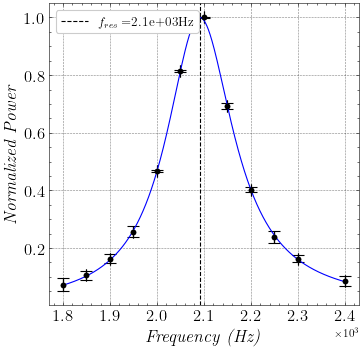

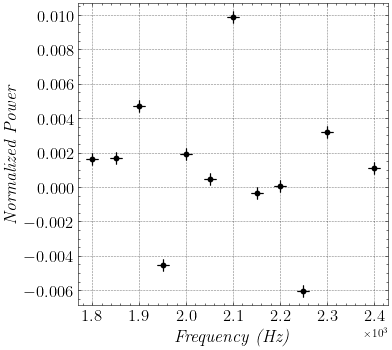

In [176]:
# PLOTTING OUR DATA
df2 = df[(df['Frequency (Hz)'] <= 2400) & (df['Frequency (Hz)'] >= 1800)]
xdata, ydata, error_x, error_y = df2['Frequency (Hz)'], df2['P_normalized'], 0, df2['P_norm_uncert']
result = FUNCTION_FIT(xdata, ydata, error_x, error_y, 'blue', 'Frequency (Hz)', 'Normalized Power', power_normalized)

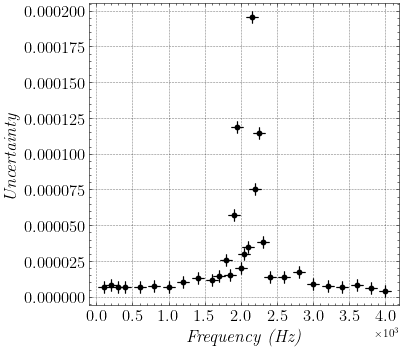

In [124]:
xdata, ydata, error_x, error_y = df['Frequency (Hz)'], df['P_uncert'], 0, 0
ScatterPlot(xdata,ydata,error_x,error_y,'green','Frequency (Hz)','Uncertainty')

In [171]:
LR, dLR, f0, df0 = result[1][0], result[2][0], result[1][1], result[2][1]

In [168]:
# DETERMING THE %ERROR
error = abs((f0-f0_theor)/f0_theor)*100
print("Percentage error: ", error, "%")
exp_precision = 100*f0/df0
print('Experimental precision:', exp_precision, '%')
print('Sigmas:', error/exp_precision)

Percentage error:  1.7809924652851983 %
Experimental precision: 626746.2271894497 %
Sigmas: 2.8416484823080535e-06


In [169]:
# DETERMING THE %ERROR
error = abs((LR-L/R)/(L/R))*100
print("Percentage error: ", error, "%")
exp_precision = 100*LR/dLR
print('Experimental precision:', exp_precision, '%')
print('Sigmas:', error/exp_precision)

Percentage error:  31.500343668715747 %
Experimental precision: 25147.321067682915 %
Sigmas: 0.001252632182328048


In [174]:
2*np.pi*f0_theor*L/R

17.21325931647741

___
### AC Analysis
___

In [62]:
sensitivity = 2 #mV
I0, dI0 = 107, 0.5 # mA
resistance = 2 # Ohms
AC_voltage = lambda params : (params[0]/10)*sensitivity # mV [v]
slope, delta_slope = 100.717582, 0.312282 # Gauss/Amp
d_0 = lambda params : 0.5*(params[1]/params[0])*180/np.pi # Degrees [I, Delta_I]
current = lambda params : params[0]*1e-3/resistance # Amps [RMS]
B = lambda params : params[0]*params[1] # [slope, current]

In [63]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1ArdS5-85nVQrc0nXAWkhlrrFFfuVR3TgFWdC-nMVErU'
workSheetName = 'AC_Day3'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , 1:6]

# CALCULATIONS 
df['AC Voltage (mV)'] = df.apply(lambda x: AC_voltage([x['Monitor Voltage V']]), axis=1)
df['dAC (mV)'] = df.apply(lambda x: uncertainty_var([x['Monitor Voltage V']], [x['Uncertanty']], AC_voltage), axis=1)
df['Angle (degrees)'] = df.apply(lambda x: d_0([I0, x['AC Voltage (mV)']]), axis=1)
df['Delta Angle (degrees)'] = df.apply(lambda x: uncertainty_var([I0, x['AC Voltage (mV)']], [dI0, x['dAC (mV)']], d_0), axis=1)
df['AC Current (A)'] = df.apply(lambda x: current([x['RMS Voltage mV']]), axis=1)
df['Delta AC Current (A)'] = df.apply(lambda x: uncertainty_var([x['RMS Voltage mV']], [x['Uncertainty mV']], current), axis=1)
df['B (Gauss)'] = df.apply(lambda x: B([slope, x['AC Current (A)']]), axis=1)
df['delta B (Gauss)'] = df.apply(lambda x: uncertainty_var([slope, x['AC Current (A)']], [delta_slope, x['Delta AC Current (A)']], B), axis=1)
df

,Gain,Monitor Voltage V,Uncertanty,RMS Voltage mV,Uncertainty mV,AC Voltage (mV),dAC (mV),Angle (degrees),Delta Angle (degrees),AC Current (A),Delta AC Current (A),B (Gauss),delta B (Gauss)
0,0.9,5.530,0.010,439.0,1.0,1.1060,0.0020,0.296117,0.001484,0.2195,0.00050,22.107509,0.085056
1,0.8,4.890,0.010,389.0,1.0,0.9780,0.0020,0.261847,0.001336,0.1945,0.00050,19.589570,0.078900
2,0.7,4.290,0.010,341.0,1.0,0.8580,0.0020,0.229719,0.001200,0.1705,0.00050,17.172348,0.073287
3,0.6,3.610,0.010,287.0,1.0,0.7220,0.0020,0.193306,0.001050,0.1435,0.00050,14.452973,0.067410
4,0.5,2.950,0.010,235.0,1.0,0.5900,0.0020,0.157965,0.000912,0.1175,0.00050,11.834316,0.062309
5,0.4,2.337,0.002,187.0,1.0,0.4674,0.0004,0.125140,0.000595,0.0935,0.00050,9.417094,0.058211
6,0.3,1.703,0.004,137.0,1.0,0.3406,0.0008,0.091191,0.000477,0.0685,0.00050,6.899154,0.054714
7,0.2,1.101,0.004,89.6,0.1,0.2202,0.0008,0.058956,0.000349,0.0448,0.00005,4.512148,0.014869
8,0.1,0.505,0.001,41.0,0.1,0.1010,0.0002,0.027041,0.000137,0.0205,0.00005,2.064710,0.008145


## Fit Statistics

,Dof,p-value,$\chi^2$,$\overline{\chi}^2$
0,7,0.007554,19.210208,2.744315


## Variables

,Name,Value,Std
0,a,0.013446,0.000017
1,b,-0.001289,0.000238


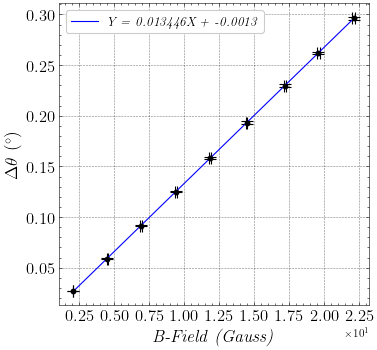

In [64]:
# PLOTTING OUR DATA FOR POSITIVE CURRENTS---------------------------------------
linear = lambda x, a, b : a*x + b
xdata, ydata, error_x, error_y = df['B (Gauss)'], df['Angle (degrees)'], df['delta B (Gauss)'], df['Delta Angle (degrees)']
result = FUNCTION_FIT_linear(xdata, ydata, error_x, error_y, 'blue', 'B-Field (Gauss)', r'$\Delta  \theta \ (^\circ)$', linear)

In [65]:
a1, da1 = result[0], result[2]
a1, da1

(0.013446431094730796, 1.7467935384002226e-05)

In [66]:
verdet = lambda params : params[0]/10 # params = [slope]
verdet_exp, verdet_unc = verdet([a1]), uncertainty_var([a1], [da1], verdet)
verdet_exp, verdet_unc

(0.0013446431094730797, 1.746793538400307e-06)

In [67]:
# DETERMING THE %ERROR
verdet_theor = 0.0013
error = abs((verdet_exp-verdet_theor)/verdet_theor)*100
print("Percentage error: ", error, "%")
exp_precision = 100*verdet_exp/verdet_unc
print('Experimental precision:', exp_precision, '%')
print('Sigmas:', error/exp_precision)

Percentage error:  3.434085344083055 %
Experimental precision: 76977.79273356414 %
Sigmas: 4.461137715352693e-05
